In [1]:
using Pkg 
Pkg.activate(".")
# Pkg.add([
#     "Lux", # for defining neural networks 
#     "Random", # for defininig random seed 
#     "LinearAlgebra",
#     "DiffEqFlux", # for using differential equations with NN -> UDE 
#     "ComponentArrays", # for structuring NN parameters 
#     "Optimization", 
#     "OptimizationOptimisers" # for optimization algorithms -> adam, stochastic gradient descent -> help us minimize loss faster 
# ])
using Lux
using Random
using LinearAlgebra
using DiffEqFlux
using DifferentialEquations
using ComponentArrays
using Optimization
using OptimizationOptimisers
using Plots

  Activating project at `C:\Users\Mrinmay Dev Sarma\scientific-ml`


> Note: In this entire notebook, true=ground_truth

## Simulating the Damped Spring-Mass System

We begin by defining the "ground truth" model for our physical system: a damped spring-mass oscillator. The behavior of this system is governed by a second-order ordinary differential equation (ODE):

$$
m \frac{d^2x}{dt^2} + c\frac{dx}{dt} + kx = 0
$$

where:
-   `x(t)` is the displacement of the mass from its equilibrium position.
-   `m` is the mass.
-   `c` is the damping coefficient (this is the term we will pretend is unknown).
-   `k` is the spring constant.

To solve this numerically, we convert it into a system of two first-order ODEs. Let `u_1 = x` (displacement) and `u_2 = dx/dt` (velocity). The system becomes:

$$
\frac{du_1}{dt} = u_2
$$
$$
\frac{du_2}{dt} = -\frac{k}{m} u_1 - \frac{c}{m} u_2
$$

In the following code cell, we will:
1.  Define the parameters `m`, `k`, and the "true" `c`.
2.  Solve this system of ODEs over a specific time interval to generate the exact trajectory (`u_1(t)`, `u_2(t)`).
3.  Add some random noise to this data to simulate a realistic measurement scenario. This noisy data will serve as our training data.

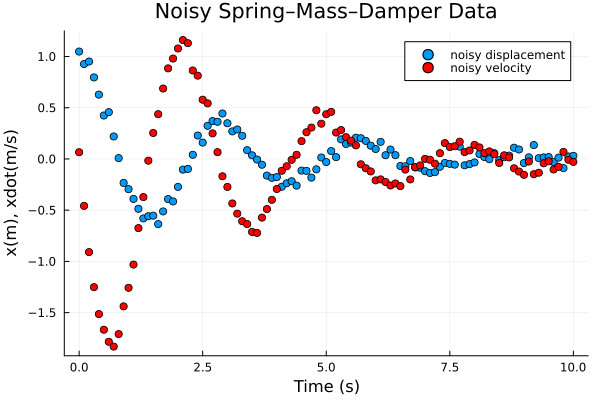

In [5]:
# 1. Generating Synthetic Data - our ground truth against which we shall compare our NN+diffEqn prediction.
# This will be our experimental data 

# fixed physical/machanical parameter
m = 1.0 
k = 5.0 
c_true = 0.7 # we do not have this in practice. Using it only to generate 

# defining ODE for true damped spring-mass system 
function true_spring_mass!(du,u,p,t) # du - derivative vector. In our case, it is [dx/dt, d^2x/dt^2].
    # so du[1]=dx/dt and du[2]=d^2x/dt^2
    x, x_dot = u # u - current state - x = displacement and x_dot = velocity. By default, when you pass in u0 to ODEProblem fn 
    # u0 will help initialize x and x_dot respectively. u is called the state vector. Here it is having [x,dx/dt]
    du[1] = x_dot # dx/dt - velocity - given initially 
    du[2]=  -(c_true/m)*x_dot - (k/m)*x   # not given, so had to derive it from the diff eqn - Newtons second law 
end 

# initial conditions for displacement and velocity at time t=0
u0 = [1.0,0.0] 

# time span and time step for simulation - we will simulate for 10 secs with increment of 0.1s (tsteps_full)
tspan = (0.0,10.0)
tsteps = 0.0:0.1:10.0

# creating ODEProblem using the true_spring_mass function defined above 
prob_true = ODEProblem(true_spring_mass!,u0,tspan) 
# solving the problem using TSit numerical integration solver 
sol_true = solve(prob_true, Tsit5(); saveat=tsteps)

# extract noise free displacement and velocity from sol (contains state vector - x and xdot at each time frame) 
# we are storing noise free x and xdot now to generate data with gaussian noise!  
x_true = [u[1] for u in sol_true.u] 
v_true = [u[2] for u in sol_true.u] 

# storing the time frames in a variable as well - [0.0, 0.1, 0.2,.....,10.0]
t_true = sol_true.t 

# adding noise to simulate real-world measurements 
noise_level = 0.05 
Random.seed!(1234)
x_noisy = x_true .+ noise_level .* randn(length(x_true))
v_noisy = v_true .+ noise_level .* randn(length(v_true)) 

# arranging noisy data into 2*N matrix - right now x_noisy and v_noisy are both 1*N 
data = vcat(x_noisy', v_noisy') 

# Plotting the noisy data 
Plots.plot(
    t_true,
    x_noisy,
    seriestype= :scatter,
    label     = "noisy displacement",
    xlabel    = "Time (s)",
    ylabel    = "x(m), xdot(m/s)",
    title     = "Noisy Spring–Mass–Damper Data"
)

Plots.scatter!(
    t_true,
    v_noisy,
    label = "noisy velocity",
    color = :red
)


In [22]:
# 2. Creating the training subset 

# we shall use only half of the data for training and other half we will predict 
train_ratio = 0.3
# ntrain - number of data points to use in our training set 
n_train = Int(round(length(t_true)*train_ratio))
# t_true goes from 0.0 to 10.0 (inclusive) with step size as 0.1. So we have 101 datapoints -> so t_train -> [0.0, ]
t_train = t_true[1:n_train] 
# take 50% of the data from x_noisy and v_noisy 
data_train = data[:, 1:n_train] # take all rows and 50% of the columns from the 2*N matrix of x_noisy and v_noisy 
# tspan for setting up ODE problem in training 
tspan_train = (t_train[1], t_train[end])

(0.0, 2.9)

In [23]:
# 3. Defining the neural network 
# We will use it to learn the damping term cdx/dt (known term is kx)

rng = Random.default_rng() # rng - random number generator
Random.seed!(42) # fixes the random seed so that NN is reproduceable

NN = Lux.Chain(
    Lux.Dense(2,10,tanh), # 1st layer - two input neurons (x,xdot) -> ten hidden neurons with tanh activation each 
    Lux.Dense(10,1) # 2nd layer - 10 input neurons (with tanh activation) -> 1 scaler output (the damping constant)
)
# output of the above NN would be the unknown damping term. As inside the ODEProblem function, accelaration = -(k/m)*x-(c/m)*xdot 
# we will make our NN predict this "c" term 

# p-init - container to hold all the parameters (weights and biases) of my NN and st-init to store any layer state 
# Lux.setup initializes NN parameters (p_init) and any internal states (st_init) using the random number generator rng 
p_init, st_init = Lux.setup(rng,NN) 

# We wrap the NN parameters in a ComponentArray with the key :nn for easier integration with the Optimization.jl workflow.
# This step makes it convenient to treat the NN's parameters as a single structured object "p_init", which we can pass to the ODE solver or optimizer.
p_init = ComponentArray(nn = p_init)


ComponentVector{Float32}(nn = (layer_1 = (weight = Float32[-0.18582273 0.096076176; -1.3326262 -0.06931201; … ; -1.9026818 1.0208838; 0.11028815 -0.5211429], bias = Float32[-0.3815964, -0.664418, 0.19913298, -0.5949118, -0.291091, 0.23158875, -0.30885977, -0.011231461, 0.5811978, 0.30154747]), layer_2 = (weight = Float32[0.24759129 -0.3664693 … 0.3706789 -0.357375], bias = Float32[-0.0878562])))

## Defining the Universal Differential Equation (UDE)

Now, we formulate the core of our problem: the Universal Differential Equation (UDE). We assume that we know the spring-mass dynamics but that the damping term is unknown. Our goal is to use a neural network, `NN(u_2, p)`, to learn this unknown function from the data we generated.

Our new hybrid model, the UDE, is:

$$
\frac{du_1}{dt} = u_2
$$
$$
\frac{du_2}{dt} = -\frac{k}{m} u_1 - \text{NN}(u_2, p)
$$

Here:
- The term `-k/m * u_1` represents the known physics (the spring's restoring force).
- `NN(u_2, p)` is a neural network that takes the velocity `u_2` as input and is parameterized by a set of trainable weights `p`. This network will approximate the unknown damping term `- (c/m) * u_2`.

By embedding the neural network directly into our differential equation, we create a model that respects the known physical laws while having the flexibility to learn complex, unknown dynamics from data.

In [24]:
# 4. Building the UDE (known -k*x/m + unkowned damping term from NN) 
# here we finally add the unknown damping term in the differential equation using a NN which makes it an universal differential equation
# it is not strictly a differential equation only because in the complete diff eqn m(d^2x/dt^2)+kx+NN(input,learnt params, states)=0,
# the NN() term is not a diff eqn term 

function ude_spring_mass!(du,u,p,t)
    # 'p': parameters that include our NN parameters (p.nn)
    x,x_dot = u 
    # Evaluate the NN at the current state (x, xdot). The NN returns a vector of length 1, so we take [1][1] to extract that scalar.
    damp_val = NN([x,x_dot],p.nn, st_init)[1][1] 
    du[1] = x_dot 
    du[2] = -(k/m)*x - (1.0/m)*damp_val
end 

prob_ude = ODEProblem(ude_spring_mass!,u0,tspan_train) # note that tspan_train and t_train are different things!

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 2.9)
u0: 2-element Vector{Float64}:
 1.0
 0.0

## Training the Neural Network

With the UDE defined, the next step is to train the neural network's parameters `p`. We achieve this by finding the parameters that make the solution of the UDE best fit our noisy training data.

The training process involves these key components:

1.  **Prediction**: For a given set of parameters `p`, we solve the UDE defined in the previous step to get a predicted trajectory, `u_pred(t)`.
2.  **Loss Function**: We define a loss function `L(p)` that quantifies the mismatch between our prediction and the actual (noisy) data. A common choice is the sum of squared errors:

    $$
    L(p) = \sum_{i=1}^{N} \left\| \mathbf{u}_{\text{pred}}(t_i; p) - \mathbf{u}_{\text{data}}(t_i) \right\|^2
    $$

    where the sum is over all `N` data points.

3.  **Optimization**: We use an optimization algorithm, such as Adam, to iteratively adjust the parameters `p` in order to minimize the loss function `L(p)`. The algorithm calculates the gradient of the loss with respect to the parameters (`∇L(p)`) and takes a step in the direction that most reduces the loss.

This process effectively "teaches" the neural network the underlying damping dynamics that were missing from our initial model.

In [25]:
# 5. Prediction and Loss 

function predict_spring(z) # will later say z=p_init when calling it, because NN will optimize its params (initially p_init) 
    sol = solve(prob_ude, Tsit5(); p=z,saveat=t_train)
    # we will now convert the solution into a 2*ntrain vector where 
    # row1 - predicted displacement 
    # row2 - predicted velocity 
    return Array(sol) 
end 

function loss_spring(z)
    # get predicted x and xdot using current parameters 0
    pred = predict_spring(z)
    return sum(abs2, (data_train .- pred))
end

loss_spring (generic function with 1 method)

Iter = 2 | Loss = 1.5057607177971648
Iter = 4 | Loss = 0.906495135637016
Iter = 6 | Loss = 0.5497893518950908
Iter = 8 | Loss = 0.33297325130953964
Iter = 10 | Loss = 0.2166422019263546
Iter = 12 | Loss = 0.1878626698992504
Iter = 14 | Loss = 0.21647860001673294
Iter = 16 | Loss = 0.25590823839647775
Iter = 18 | Loss = 0.27928821796960124
Iter = 20 | Loss = 0.285347622298838
Iter = 22 | Loss = 0.27704897122914457
Iter = 24 | Loss = 0.25503752758130904
Iter = 26 | Loss = 0.22518686942334068
Iter = 28 | Loss = 0.19879518737843074
Iter = 30 | Loss = 0.18173315807959262
Iter = 32 | Loss = 0.17314009767522465
Iter = 34 | Loss = 0.17093141678148208
Iter = 36 | Loss = 0.17380067100517874
Iter = 38 | Loss = 0.17833128881937096
Iter = 40 | Loss = 0.18045283862457306
Iter = 42 | Loss = 0.17931983388101094
Iter = 44 | Loss = 0.17621014497452706
Iter = 46 | Loss = 0.17192084355892517
Iter = 48 | Loss = 0.16742504605045486
Iter = 50 | Loss = 0.1642332929946752
Final ADAM loss = 0.1642332929946752


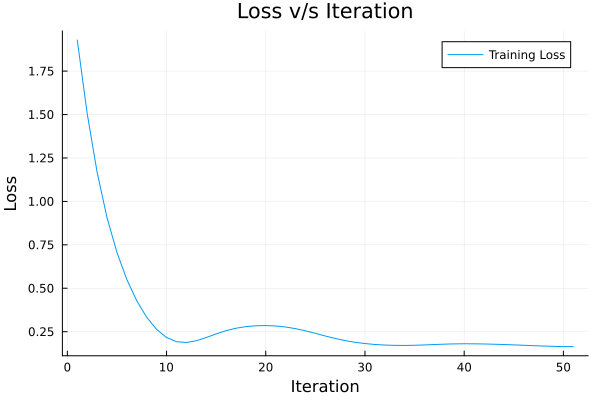

In [26]:
# 6. Updating parameters of NN using ADAM optimizer 

# since we have the loss function now (from loss-spring), we have converted our ML problem to an optimization problem. The Optimization
# module helps us define and solve optimization problems in a uniform interface 

# AutoZygote is a tool in Optimization that tells Optimization.jl to compute gradients of loss fn via the Zygote.jl  
adtype = Optimization.AutoZygote() 

# now we'll create an optimization fn that uses the loss_spring fn and adtye (stores that method we want to use to compute derivatives)
# optf now is a function object that knows what to minimize (result of loss_spring) and how to minimize (zygote method) 
opt_f = Optimization.OptimizationFunction((x,p)->loss_spring(x), adtype) 

# now we need to define an optimization problem that takes the optf and also the initial setup of paramters of NN we want to optimize! 
# it is like saying - “Here’s the function and here’s the initial guess. Now go solve this optimization problem
# this gives us a complete problem to pass to an optimizer
opt_prob = Optimization.OptimizationProblem(opt_f, p_init)

losses = Float64[] # to store loss values over iterations 
iter_count = 0 # to store the current iteration count 

function callback(p, l) # p - current parameter vector of NN weights and biases and l - current loss 
    global iter_count
    iter_count += 1
    push!(losses, l)
    # At each optimization step, we increment 'iter_count' and record the loss 'l'.
    if iter_count % 2 == 0
        println("Iter = $iter_count | Loss = $l")
    end
    return false
end 

# We solve the optimization problem using the ADAM optimizer with a learning rate of 0.01. 'callback' is invoked each iteration
res_adam = Optimization.solve(
    opt_prob, 
    OptimizationOptimisers.ADAM(0.01), 
    callback = callback,
    maxiters = 50 
)

println("Final ADAM loss = ", losses[end]) 


# plotting loss values against iterations
Plots.plot(
    1:iter_count, # x-axis - from 1 to iter_count 
    losses, # y-axis - loss value in losses array 
    label = "Training Loss", 
    xlabel = "Iteration",
    ylabel = "Loss",
    title = "Loss v/s Iteration"
)

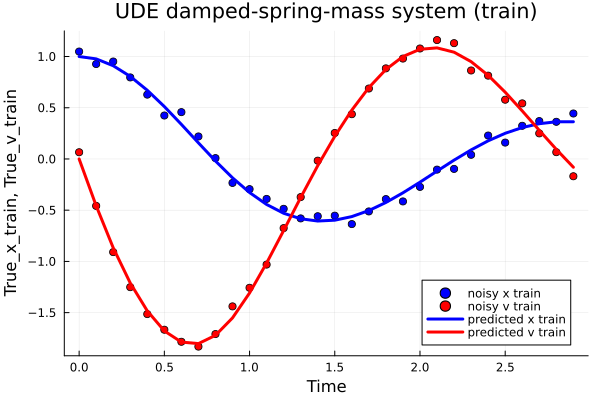

In [27]:
# Vizualizing training results 

# using the learned neural network parameters from res_adam to make predictions
pred_final = predict_spring(res_adam.u)
# pred_final is a 2*N array with the 1st row being predicted displacement and the 2nd row being predicted velocity 
x_pred = pred_final[1, :] # take 1st row and all columns 
v_pred = pred_final[2, :] # take 2nd row and all columns

# plotting the noisy data (in data_train) first, on top of which we will plot our predicted x and v (or x_dot)
Plots.plot(
    t_train, 
    data_train[1,:], 
    seriestype= :scatter,
    xlabel = "Time", 
    ylabel = "True_x_train, True_v_train", 
    label = "noisy x train", 
    color = :blue,
    title = "UDE damped-spring-mass system (train)"
)

Plots.scatter!(t_train, data_train[2,:], label="noisy v train", color=:red)

# plotting predicted x and v 
Plots.plot!(t_train, x_pred, label="predicted x train", color = :blue, lw = 3)
Plots.plot!(t_train, v_pred, label="predicted v train", color= :red, lw=3) 

## Forecasting using our UDE

After training, our neural network `NN(u_2, p*)` (with the optimized parameters `p*`) now contains a data-driven approximation of the unknown damping term. The final step is to use this fully-learned UDE to make predictions and evaluate its performance.

We use the trained UDE to forecast the system's behavior over a longer time horizon (10 seconds, in this case) to see how well it generalizes beyond the training data's time span. The governing equations are now:

$$
\frac{du_1}{dt} = u_2
$$
$$
\frac{du_2}{dt} = -\frac{k}{m} u_1 - \text{NN}(u_2, p^*)
$$

By plotting the forecasted trajectory against the true trajectory, we can visually assess the accuracy of our discovered model. We can also compare the output of our learned function `NN(u_2, p*)` directly against the true damping term `- (c/m) * u_2` to see if the UDE has successfully recovered the underlying physics.

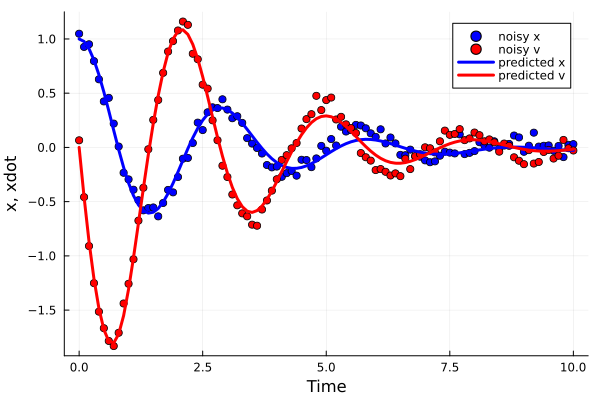

In [30]:
# 8. Final Plot (extrapolated to the whole time interval - 10 secs) 

function ude_spring_mass_ext!(du,u,p,t)
    x,xdot = u 
    damp_val = NN([x,xdot], p.nn, st_init)[1][1]
    du[1] = xdot 
    du[2] = -(k/m)x - (1/m)*damp_val
end

prob_ext = ODEProblem(ude_spring_mass_ext!,u0,tspan)
sol_ext = solve(prob_ext, Tsit5(); p=res_adam.u, saveat=tsteps) 
x_ext = [u[1] for u in sol_ext.u] 
v_ext = [u[2] for u in sol_ext.u]
t_ext = sol_ext.t 

# plotting noisy data first 
Plots.plot(
    t_ext,
    x_noisy, 
    seriestype = :scatter, 
    color = :blue,
    label="noisy x",
    xlabel="Time",
    ylabel="x, xdot"  
)

Plots.scatter!(t_ext,v_noisy, color = :red, label="noisy v")

# then we will plot prediction for the full time interval 
Plots.plot!(t_ext, x_ext, color=:blue, label="predicted x", lw=3) 
Plots.plot!(t_ext, v_ext, color=:red, label="predicted v", lw=3)
